In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import init
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt


import random
import numpy as np
seed = 433
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('data/input.txt', 'r') as f:
    words = f.read().splitlines()

words_size = len(words)
max_word_length = max(len(word) for word in words)
print(max_word_length)
print(words_size)
print(words[:10])

15
32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [54]:
chars = sorted(list(set("".join(words))))
vocab_size = len(chars)
print(vocab_size)
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
vocab_size += 1  # <START>
itos = {i: s for s, i in stoi.items()}

26


In [55]:
def build_dataset(words, max_word_length, vocab_size):
    xs = torch.zeros((len(words), max_word_length + 1), dtype=torch.long)
    ys = torch.full((len(words), max_word_length + 1), fill_value=-1, dtype=torch.long)

    for idx, word in enumerate(words):

        encoded = [stoi[c] for c in word]
        xs[idx, 1:len(encoded)+1] = torch.tensor(encoded)
        ys[idx, :len(encoded)] = torch.tensor(encoded)
        ys[idx, len(encoded)] = 0

    return xs, ys


# shuffle the words
indices = torch.randperm(len(words))
words = [words[i] for i in indices]
train_words = words[:int(len(words) * 0.9)]
test_words = words[int(len(words) * 0.9):]
train_data, train_targets = build_dataset(train_words, max_word_length, vocab_size)
test_data, test_targets = build_dataset(test_words, max_word_length, vocab_size)
train_words = set(train_words)
test_words = set(test_words)
print("train data size:", len(train_data))
print("test data size:", len(test_data))
print(train_data[0])
print(train_targets[0])

train data size: 28829
test data size: 3204
tensor([ 0, 25, 15,  3,  5, 12,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0])
tensor([25, 15,  3,  5, 12,  9, 14,  0, -1, -1, -1, -1, -1, -1, -1, -1])


In [56]:
class MLP(nn.Module):
    def __init__(self, block_size, vocab_size, n_embd, n_hidden, dropout=0.25):
        super().__init__()
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.n_emnd = n_embd
        self.n_hidden = n_hidden
        self.encoder = nn.Embedding(vocab_size+1, n_embd)
        self.fc = nn.Linear(block_size * n_embd, n_hidden)
        self.bn = nn.BatchNorm1d(n_hidden)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(n_hidden, vocab_size)
        init.normal_(self.decoder.weight, mean=0, std=0.01)
        init.kaiming_normal_(self.fc.weight, nonlinearity='tanh')

    def forward(self, idx: torch.Tensor, y=None):
        # idx (B, T)
        # y (B, T)
        B, T = idx.shape[0], idx.shape[1]
        embs = []

        def print_sequence(idx):
            idx_list = []
            for i in range(self.block_size):
                idx_list.append(idx.view(B, T, 1))
                idx = torch.roll(idx, 1, 1)
                idx[:, 0] = self.vocab_size  # special <BLANK> token
            idxs = torch.cat(idx_list, -1)
            print(idxs[0])
            print(y[0])

        # print_sequence(idx)

        for k in range(self.block_size):
            tok_emb = self.encoder(idx)  # (B, T, C)
            idx = torch.roll(idx, 1, 1)
            idx[:, 0] = self.vocab_size  # special <BLANK> token
            embs.append(tok_emb)
        x = torch.cat(embs, -1)  # (B, T, T*C)
        x = self.fc(x)  # (B, T, n_hidden)
        x = x.view(-1, self.n_hidden)  # (B*T, n_hidden)
        x = self.bn(x)
        x = x.view(B, T, self.n_hidden)  # (B, T, n_hidden)
        x = self.tanh(x)
        x = self.dropout(x)
        logits = self.decoder(x)  # (B, T, vocab_size)
        loss = None
        if y is not None:
            # (B*T, vocab_size), (B*T)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

        return logits, loss


class DeepMLP(nn.Module):
    def __init__(self, block_size, vocab_size, n_embd, n_hidden, dropout=0.25):
        super().__init__()
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.n_emnd = n_embd
        self.n_hidden = n_hidden
        self.encoder = nn.Embedding(vocab_size+1, n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(block_size * n_embd, 8*n_hidden),  nn.ReLU(), nn.BatchNorm1d(8*n_hidden), nn.Dropout(dropout),
            nn.Linear(8*n_hidden, 6*n_hidden),  nn.ReLU(), nn.BatchNorm1d(6*n_hidden), nn.Dropout(dropout),
            nn.Linear(6*n_hidden, 4*n_hidden),  nn.ReLU(), nn.BatchNorm1d(4*n_hidden), nn.Dropout(dropout),
            nn.Linear(4*n_hidden, 2*n_hidden),  nn.ReLU(), nn.BatchNorm1d(2*n_hidden), nn.Dropout(dropout),
            nn.Linear(2*n_hidden, n_hidden), nn.ReLU(),  nn.BatchNorm1d(n_hidden), nn.Dropout(dropout),
        )
        self.decoder = nn.Linear(n_hidden, vocab_size)

    def forward(self, idx: torch.Tensor, y=None):
        # idx (B, T)
        # y (B, T)
        B, T = idx.shape[0], idx.shape[1]
        embs = []

        for k in range(self.block_size):
            tok_emb = self.encoder(idx)  # (B, T, C)
            idx = torch.roll(idx, 1, 1)
            idx[:, 0] = self.vocab_size  # special <BLANK> token
            embs.append(tok_emb)

        x = torch.cat(embs, -1)  # (B, T, self.block_size*C)
        x = x.view(B*T, self.block_size*self.n_emnd)  # (B*T, self.block_size*C)
        x = self.mlp(x)
        logits = self.decoder(x)  # (B*T, vocab_size)
        loss = None
        if y is not None:
            # (B*T, vocab_size), (B*T)
            loss = F.cross_entropy(logits, y.view(-1), ignore_index=-1)

        return logits.view(B, T, self.vocab_size), loss

In [57]:
class RNNCell(nn.Module):
    def __init__(self, n_input, n_hidden):
        super().__init__()
        self.ih_hh = nn.Linear(n_input + n_hidden, n_hidden)
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        combined = torch.cat([x, h], dim=-1)  # (B, n_hidden+n_input)
        h_next = self.tanh(self.ih_hh(combined))  # (B, n_hidden)
        return h_next


class GRUCell(nn.Module):
    def __init__(self, n_input, n_hidden):
        super().__init__()
        self.reset_gate = nn.Linear(n_input + n_hidden, n_hidden)
        self.update_gate = nn.Linear(n_input + n_hidden, n_hidden)
        self.candidate_state = nn.Linear(n_input + n_hidden, n_hidden)

    def forward(self, x, h):
        combined = torch.cat([x, h], dim=-1)  # (B, n_hidden+n_input)
        update = F.sigmoid(self.update_gate(combined))  # (B, 1)
        reset = F.sigmoid(self.reset_gate(combined))  # (B, 1)
        combined_with_reset = torch.cat([x, h * reset], dim=-1)  # (B, n_hidden+n_input)
        h_tilde = F.tanh(self.candidate_state(combined_with_reset))
        h_next = h_tilde * update + (1-update) * h
        return h_next


class RNN(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, cell_type='rnn'):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_emnd = n_embd
        self.n_hidden = n_hidden
        if cell_type == 'rnn':
            self.cell = RNNCell(n_embd, n_hidden)
        elif cell_type == 'gru':
            self.cell = GRUCell(n_embd, n_hidden)
        self.encoder = nn.Embedding(vocab_size, n_embd)
        self.decoder = nn.Linear(n_hidden, vocab_size)

    def forward(self, idx, y=None):
        # idx (B, T)
        # y (B, T)
        B, T = idx.shape[0], idx.shape[1]
        x = self.encoder(idx)  # (B, T, C)
        h = torch.zeros(B, self.n_hidden)
        outputs = []
        for i in range(T):
            xt = x[:, i, :]
            h = self.cell(xt, h)  # (B, n_embd) -> (B, n_hidden)
            out = self.decoder(h)  # (B, vocab_size)
            outputs.append(out)
        logits = torch.stack(outputs, dim=1)  # (B, T, vocab_size)
        loss = None
        if y is not None:
            # (B*T, vocab_size), (B*T)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
        return logits, loss

In [58]:
class LSTM(nn.Module):
    def __init__(self, block_size, vocab_size, n_embd, n_hidden):
        super().__init__()
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.n_emnd = n_embd
        self.n_hidden = n_hidden
        self.encoder = nn.Embedding(vocab_size, n_embd)
        self.decoder = nn.Linear(n_hidden, vocab_size)

        self.xh_to_f = nn.Linear(n_hidden+n_embd, n_hidden)
        self.xh_to_i = nn.Linear(n_hidden+n_embd, n_hidden)
        self.xh_to_c = nn.Linear(n_hidden+n_embd, n_hidden)
        self.xh_to_o = nn.Linear(n_hidden+n_embd, n_hidden)

    def forward_lstm(self, x, h, c):
        xh = torch.cat([x, h], dim=-1)  # (B, n_hidden+n_embd)
        f = F.sigmoid(self.xh_to_f(xh))
        i = F.sigmoid(self.xh_to_i(xh))
        o = F.sigmoid(self.xh_to_o(xh))
        c_tilde = F.tanh(self.xh_to_c(xh))
        c_next = c * f + c_tilde * i
        h_next = o * F.tanh(c_next)
        return h_next, c_next

    def forward(self, idx, y=None):
        # idx (B, T)
        # y (B, T)
        B, T = idx.shape[0], idx.shape[1]
        x = self.encoder(idx)  # (B, T, C)
        h = torch.zeros(B, self.n_hidden)
        c = torch.zeros(B, self.n_hidden)
        outputs = []
        for i in range(T):
            xt = x[:, i, :]  # (B, n_embd)
            h, c = self.forward_lstm(xt, h, c)
            out = self.decoder(h)  # (B, vocab_size)
            outputs.append(out)
        logits = torch.stack(outputs, dim=1)  # (B, T, vocab_size)
        loss = None
        if y is not None:
            # (B*T, vocab_size), (B*T)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
        return logits, loss

In [59]:
# PyTorch's GRU
class TorchGRU(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.n_hidden = n_hidden
        self.encoder = nn.Embedding(vocab_size, n_embd)
        self.rnn = nn.GRU(n_embd, n_hidden, batch_first=True)
        self.decoder = nn.Linear(n_hidden, vocab_size)

    def forward(self, idx, y=None):
        B, T = idx.shape[0], idx.shape[1]
        x = self.encoder(idx)  # (B, T, C)
        h = torch.randn(1, B, self.n_hidden)
        outputs, h = self.rnn(x, h)  # (B, T, hidden_size)
        logits = self.decoder(outputs)  # (B, T, vocab_size)
        loss = None
        if y is not None:
            # (B*T, vocab_size), (B*T)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
        return logits, loss

In [60]:
# Transformer


class Head(nn.Module):
    def __init__(self, n_embd, head_size):
        super().__init__()
        self.query = nn.Linear(n_embd, head_size)
        self.key = nn.Linear(n_embd, head_size)
        self.value = nn.Linear(n_embd, head_size)
        self.register_buffer("mask", torch.tril(torch.ones(2048, 2048)))  # 创建下三角掩码

    def forward(self, x):
        # x: (B, T, n_embd)

        B, T = x.shape[0], x.shape[1]
        q = self.query(x)  # (B, T, head_size)
        k = self.key(x)
        v = self.value(x)
        attn = q @ k.transpose(-2, -1)  # (B, T, T)
        attn = attn * (k.size(-1) ** -0.5)
        attn = attn.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attn = F.softmax(attn, dim=-1)  # (B, T, T)

        out = attn @ v  # (B, T, head_size)
        return out


class MultiHead(nn.Module):
    def __init__(self, n_embd, head_size, n_head):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embd, head_size) for _ in range(n_head)])
        self.fc = nn.Linear(n_head * head_size, n_embd)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # 并行处理多头注意力
        attns = [head(x) for head in self.heads]
        out = torch.cat(attns, dim=-1)
        out = self.dropout(self.fc(out))
        return out


class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # 扩展维度
            nn.GELU(),  # 激活函数
            nn.Linear(4 * n_embd, n_embd),  # 恢复维度
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd, head_size, n_head, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.sa = MultiHead(n_embd, head_size, n_head)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ff = FeedForward(n_embd, dropout)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x


class TransformerLM(nn.Module):
    def __init__(self, n_embd, n_head, n_layers, vocab_size, dropout=0.2):
        super().__init__()
        head_size = n_embd // n_head
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.pos_embedding = nn.Embedding(2048, n_embd)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.Sequential(*[Block(n_embd, head_size, n_head, dropout) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(n_embd)  # 最终的层归一化
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, y=None):
        # 自回归
        # idx: (B, T), y: (B, T)
        B, T = idx.shape
        # Positional Encoding?
        tok_emb = self.embedding(idx)  # (B, T, n_embd)
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0).repeat(B, 1)  # (B, T)
        pos_emb = self.pos_embedding(pos)  # (B, T, n_embd)
        x = self.dropout(tok_emb + pos_emb)

        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)  # (B, T, vocab_size)
        loss = None
        if y is not None:
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1), ignore_index=-1)
        return logits, loss

In [61]:
n_embd = 256
n_hidden = 256
batch_size = 32

block_size = 16

# model = MLP(block_size, vocab_size, n_embd, n_hidden, dropout=0.2)
# model = DeepMLP(block_size, vocab_size, n_embd, n_hidden, dropout=0.2)
# model1 = RNN(vocab_size, n_embd, n_hidden, cell_type='rnn')
# model2 = RNN(vocab_size, n_embd, n_hidden, cell_type='gru')
model = TorchGRU(vocab_size, n_embd, n_hidden)

n_head = 4
n_layers = 4
# model = TransformerLM(n_embd, n_head, n_layers, vocab_size)

In [62]:
class EvalDataSet(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


def get_dataloader(data, targets, batch_size=32):
    dataset = EvalDataSet(data, targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def evaluate(model, data, targets, name="train"):
    # evaluate model
    model.eval()
    with torch.no_grad():
        losses = []
        dataloader = get_dataloader(data, targets, batch_size)
        for x, y in dataloader:
            logits, loss = model(x, y)
            losses.append(loss.item())
        mean_loss = torch.tensor(losses).mean().item()
    model.train()
    return mean_loss


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Modify training loop to include early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.01)  # Adjust patience and min_delta as needed

In [63]:
max_iter = 10000

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01, betas=(0.9, 0.99), eps=1e-8)

eval = True
lossi = []
train_eval_lossi = []
test_eval_lossi = []
for i in range(max_iter):
    idx = torch.randint(0, len(train_data), (batch_size,))
    x, y = train_data[idx], train_targets[idx]
    # train step
    logits, loss = model(x, y)

    # loss
    # print(f"{i}, loss: {loss}")
    lossi.append(loss.item())
    if i % 50 == 0:
        print(f"{i}, loss: {loss}")
    if eval:
        if i > 0 and i % 200 == 0:
            train_loss = evaluate(model, train_data, train_targets, name="train")
            test_loss = evaluate(model, test_data, test_targets, name="test")
            print(f"[{i}] train_loss: {train_loss}, test_loss: {test_loss}")
            # print(f"[{i}] test_loss: {test_loss}")
            train_eval_lossi.append((i, train_loss))
            test_eval_lossi.append((i, test_loss))
            # Check early stopping condition
            early_stopping(test_loss)
            if early_stopping.early_stop:
                print(f"Early stopping at iteration {i}")
                break
    # backward
    optimizer.zero_grad()
    loss.backward()
    # update
    optimizer.step()


if eval:
    train_loss = evaluate(model, train_data, train_targets, name="train")
    test_loss = evaluate(model, test_data, test_targets, name="test")
    train_eval_lossi.append((i, train_loss))
    test_eval_lossi.append((i, test_loss))
    print(f"[final] train_loss: {train_loss}, test_loss: {test_loss}")

0, loss: 3.3220839500427246
50, loss: 2.359179973602295
100, loss: 2.2957351207733154
150, loss: 2.141716957092285
200, loss: 2.1434054374694824
[200] train_loss: 2.2071025371551514, test_loss: 2.203723907470703
250, loss: 2.1213786602020264
300, loss: 2.1433024406433105
350, loss: 2.174004554748535
400, loss: 2.101508140563965
[400] train_loss: 2.135890245437622, test_loss: 2.1369428634643555
450, loss: 2.1370532512664795
500, loss: 2.058128595352173
550, loss: 2.1667141914367676
600, loss: 2.0459465980529785
[600] train_loss: 2.100558280944824, test_loss: 2.1123135089874268
650, loss: 2.088155746459961
700, loss: 2.0512874126434326
750, loss: 2.077343702316284
800, loss: 2.0087265968322754
[800] train_loss: 2.07131028175354, test_loss: 2.078688144683838
850, loss: 2.0350050926208496
900, loss: 2.149463176727295
950, loss: 2.0931365489959717
1000, loss: 2.1758058071136475
[1000] train_loss: 2.049081563949585, test_loss: 2.066704511642456
1050, loss: 2.133805751800537
1100, loss: 1.983

In [64]:
def generate(model, size):
    model.eval()
    idx = torch.zeros(size, 1, dtype=torch.long)  # (B, 1)
    for i in range(max_word_length-1):
        with torch.no_grad():
            logits, loss = model(idx)  # (B, step, vocab_size)
            logits = logits[:, -1, :]  # (B, vocab_size)
            probs = F.softmax(logits, dim=-1)  # (B, vocab_size)
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1)  # (B, step+1)
    model.train()
    return idx


def print_sample(model, size):
    train_samples, test_samples, new_samples = [], [], []
    idx = generate(model, size)
    idx_list = idx[:, 1:].tolist()
    for i in idx_list:
        if 0 in i:
            i = i[:i.index(0)]
        word = ''.join([itos[i] if i < vocab_size else '-' for i in i])
        if word in train_words:
            train_samples.append(word)
        elif word in test_words:
            test_samples.append(word)
        else:
            new_samples.append(word)
    print('train samples: ', len(train_samples))
    print('test samples: ', len(test_samples))
    print('new samples: ', len(new_samples))
    print(test_samples)
    print(train_samples)
    print(new_samples)


print_sample(model, 10000)

train samples:  2986
test samples:  181
new samples:  6833
['nasi', 'romi', 'kairah', 'dailee', 'airah', 'tamyah', 'kairie', 'airah', 'harleigh', 'heli', 'lariyah', 'dayson', 'lace', 'zayley', 'reilynn', 'amariya', 'kaeleigh', 'meda', 'jesaiah', 'caydyn', 'keana', 'alayah', 'darel', 'kenlie', 'tarin', 'jaziah', 'marlan', 'jaziah', 'caralynn', 'koltan', 'ivanna', 'adaline', 'ariyanna', 'ivanna', 'analiah', 'quinleigh', 'daryan', 'raye', 'zavian', 'adyn', 'isabelle', 'tylen', 'emaya', 'jenny', 'natalee', 'jayleen', 'kaylee', 'torrion', 'levon', 'aayan', 'trevan', 'aariyah', 'jazira', 'kashlynn', 'raelie', 'adiya', 'ameira', 'keren', 'jayven', 'dayson', 'tarin', 'geremy', 'dayson', 'saman', 'eliana', 'kiera', 'ama', 'jeilany', 'amariya', 'micki', 'jamin', 'karely', 'jaliyah', 'zayvon', 'mirabella', 'terry', 'lianna', 'zamiyah', 'tamyah', 'keana', 'cyrie', 'amariah', 'ariyah', 'azael', 'sander', 'tylan', 'tamyah', 'ena', 'kelon', 'karin', 'natalee', 'zanari', 'ramyah', 'jaquis', 'amair', '

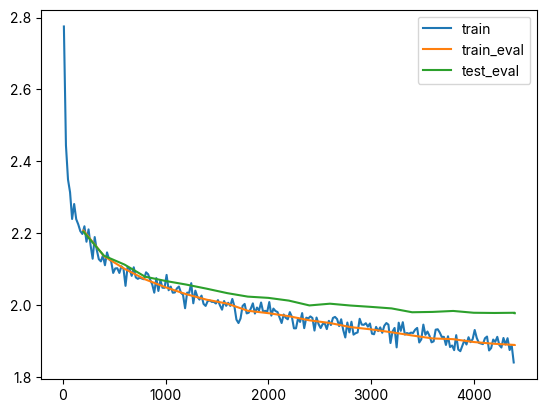

In [65]:
# 处理损失可视化，适配不是50倍数的情况
loss_step = torch.stack((torch.arange(len(lossi)), torch.tensor(lossi)), dim=1)

group_size = 20

# 计算完整的50步分组数量
num_complete_groups = len(lossi) // group_size
# 只使用完整的组进行平均
if num_complete_groups > 0:
    loss_mean = loss_step[:num_complete_groups*group_size].view(-1, group_size, 2).mean(dim=1)
    plt.plot(loss_mean[:, 0], loss_mean[:, 1], label="train")
else:
    # 如果没有完整的组，直接绘制原始数据
    plt.plot(loss_step[:, 0], loss_step[:, 1], label="train")

train_loss = torch.tensor(train_eval_lossi)
test_loss = torch.tensor(test_eval_lossi)

plt.plot(train_loss[:, 0], train_loss[:, 1], label="train_eval")
plt.plot(test_loss[:, 0], test_loss[:, 1], label="test_eval")
plt.legend()
plt.show()